## Simulating power

How do you determine the sample size necessary to obtain a real effect (with a desired probability)? The typical approach to this is to run a power analysis for known distributions, which analytically calculates how many participants you need to have in order to have an 80% chance, for example, to detect an effect. One tool to accomplish this is called [G-power](http://www.gpower.hhu.de/en.html).

The problems with using G-power and similar analytical tools are that:
- you can only use them for analyses they have implemented that have a simple analytical solution (e.g., t-tests, ANOVA). They do not offer power analyses for mixed-effects regressions and many other tools that you have learned in the class.
- they calculate power only as a function of "number of participants" - they do not take into account the fact that increasing the number of observations per participant can also increase power, by decreasing variability in individual estimates

One solution to these problems is to analyze the power to detect an effect by simulation. The idea is quite simple - you repeatedly simulate artificial data by choosing plausible parameters given the existing literature or expected effect sizes and then you run the analysis of your choice on the simulated data. The proportion of simulations in which you find a statistically significant result is the power of your study, or the probability with which you can expect to find a real effect of that size in your sample.



## Basic algorithm

Simulation power analyses follow these steps, on which we'll expand in the subsequent sections:
1. Determine the sources of variance - between subject variability, trial-by-trial variability, etc.
2. Write a **data simulation** function with the following form:
    - input: parameters that control sample size, number of trials, means and variances of conditions
    - procedure: simulate observations given these parameters
    - output: simulated dataset
3. Write an **analysis** function:
    - input: simulated dataset
    - procedure: run analysis and extract statistical significance
    - output: statistical significance value (p-value, $\Delta$AIC or $\Delta$BIC, whether confidence intervals for coefficients overlap with zero, etc.)
4. Write a loop that:
    - repeatedly runs the prior two functions for different sample sizes and numbers of trials and extracts the proportion of simulations for which the analysis is significant

### 1) Determine the sources of variance

The outcome of any statistical analysis depends on how much your observations vary as you sample them. Variance comes from many sources -- there are individual differences, noisy sampling, trial-by-trial variability, etc. Which of these variance sources you need to specify depends on the analysis you want to run.

Let's start with a simple example. Say you want to determine whether men are on average taller than women using a t-test. There is a "true" underlying difference in the population, such that if you measure the heights of all men and all women you would get the following population parameters:

$$\mu_{m} = 177 cm$$
$$\mu_w = 163 cm$$

However, because there is variability present within male and female height, if you collect 5 measurements from each group of men and women, you would get sample statistics that are similar but not identical to the population parameters. It is even possible that you would, by chance (with such a small sample) get a group of women that are on average taller than men. 

Therefore, in order to run a power analysis for a t-test comparing the height of men and women, you need to specify the expected variability of height in men and women. 

Let's say that height is normally distributed with the above means and standard deviations of:

$$\sigma_m = 7cm$$
$$\sigma_w = 6.3cm$$

Or, written more compactly:

$$Height_m \sim \mathcal{N}(\mu_m,\,\sigma_m^{2})$$
$$Height_w \sim \mathcal{N}(\mu_w,\,\sigma_w^{2})$$
$$n=5$$


### 2) Write a function to simulate artificial data
Now let's write a function to simulate some data consistent with the above parameters.

In [28]:
# a function for simulating data for two groups. Sample size is the number of people in each group
simulate_data <- function(sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    # draw observation from a normal distribution
    obs_group1 <- rnorm(sample_size, group1_mu, group1_sd)
    obs_group2 <- rnorm(sample_size, group2_mu, group2_sd)
    return(data.frame(group1=obs_group1, group2=obs_group2))
}

With the first function we can simulate the heights for 5 men and women:

In [29]:
set.seed(040819)
heights = simulate_data(sample_size = 5, group1_mu = 177, group1_sd = 7, 
                        group2_mu = 163, group2_sd = 6.3)
print(heights)

    group1   group2
1 176.2855 176.3336
2 169.7314 173.0064
3 184.1678 154.7453
4 166.8668 170.8773
5 172.8292 164.2265


### 3) Write a function to conduct your intended analysis
Now we can write a function to perform the t-test for the two groups. 

In [30]:
# a function for running a t-test and extracting p-value
run_analysis <- function(data) {
    fit <- t.test(data$group1, data$group2)
    return(fit$p.value)
}

With this second function we can run an independent samples `t.test` and extract the `p.value`:

In [31]:
run_analysis(heights)

[1] 0.2437967

Now, this particular sample did not have significantly different heights. However, this may have just been chance. If we repeat this process many times for this particular sample size, in what proportion of cases will we find a significant difference? Let's put both previous functions together to simulate the data and calculate the statistical result 1000 times. Note that we can also control the stringency of our analysis by specifying an alpha-level for the p-value. 

In [32]:
# a function for repeatedly running the t-test on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, sample_size, group1_mu, group1_sd, group2_mu, group2_sd) {
    p.values <- c() # empty vector to store p.values from each simulation
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(sample_size, group1_mu, group1_sd, group2_mu, group2_sd) # simulate the data using the defined function 
        p.value <- run_analysis(data) # call the previously defined function to run the analysis 
        p.values <- c(p.values, p.value) # add the current p.value to the vector
    }
    
    # calculate how many of the simulations had significant results 
    power <- mean(p.values <= alpha)
    return(list(power = power, p.values = p.values)) #return a list with the power as the probability of a sig. result and the corresponding p-values
}


For 1000 simulations of 5 participants per group and an alpha significance level of 0.05, we have a power of:

In [33]:
set.seed(040819)
results = repeat_analysis(n_simulations = 1000, alpha = 0.05, sample_size = 5,
                          group1_mu=177, group1_sd = 7, group2_mu = 163, group2_sd = 6.3)
results$power

[1] 0.793

This means that there is a 79.3% probability that we correctly reject the null (no difference in heights between men and women) at p < 0.05 if we measure the heights of 5 people. If we measure 10 people per group instead, we have much greater power to detect an effect:

In [41]:
set.seed(040819)
results = repeat_analysis(n_simulations = 1000, alpha = 0.05, sample_size = 10,
                          group1_mu=177, group1_sd = 7, group2_mu = 163, group2_sd = 6.3)
results$power

[1] 0.994

If we become more conservative with our statistical threshold, power decreases:

In [42]:
set.seed(18546)
results = repeat_analysis(n_simulations = 1000, alpha = 0.001, sample_size = 10,
                          group1_mu=177, group1_sd = 7, group2_mu = 163, group2_sd = 6.3)
results$power

[1] 0.756

To make it clearer, we can visualize the distribution of p.values obtained from each simulation:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


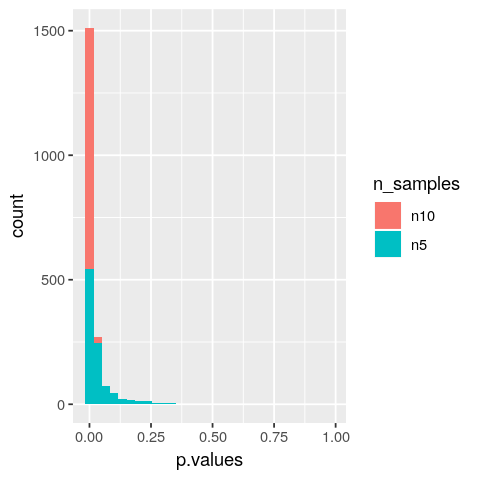

In [88]:
library(tidyverse)
options(repr.plot.width=4, repr.plot.height=4)

results_n5 = repeat_analysis(1000, 0.05, 5, 177, 7, 163, 6.3)
results_n10 = repeat_analysis(1000, 0.05, 10, 177, 7, 163, 6.3)


power_df = data.frame(cbind(n5 = results_n5$p.values, n10 = results_n10$p.values)) %>% 
            gather('n_samples', c('n5', 'n10'), value = 'p.values')


ggplot(power_df, aes(p.values, fill=n_samples)) + geom_histogram() 

### 3) Vary the sample size (number of trials or number of subjects)

Before, we asked what the power was when we varied the number of samples, or the number of people that we collected data from. Now, for the inverse question. How many **people** do we need to be 95% certain that we will detect the true significant difference in heights between men and women? Yes, you could manually vary the above function's parameters until you obtain a desired level of power, but we can instead simulate data for different sample sizes in an automated way and choose the sample size that gives us the desired power. 

<br><br>

To do this, we can use the `tidyverse` package to create a dataframe with parameters, then simulate data for each row of the dataframe, store the results in a column, then run the analysis on that column and store the resulting p.value. If you need a reminder of the details of tidyverse, revisit this [tutorial](https://github.com/CoAxLab/DataSciencePsychNeuro_CMU85732/blob/master/RecitationNotebooks/Recitation02_modelObjects_tidydata.ipynb).

In [103]:
# first, create a data.frame to store the results
dat <- expand.grid(sample_size = 2:20, alpha = c(0.05,0.01,0.001)) #vary the criterion for sig. and the sample size
dat$id <- 1:nrow(dat) #identify each combination of parameters as a separate parameter case for below 

# then use tidyverse functions to run the analysis for each sample size
results <- dat  %>%  #using the df defined above
    nest(-id, .key = 'parameters')  %>% #separate the parameters into lists split by case and call the new column of lists 'parameters' 
    mutate(power = map(parameters, ~ repeat_analysis(1000, .$alpha, .$sample_size, 177, 7, 163, 6.3)$power))  %>% 
    #for each case within parameters, repeat the analysis, varying the alpha and sample size
    #store the power associated with all cases as a new variable called power 
    unnest(parameters, power) #return the dataframe to an unnested state, making each element of the list its own row

In [162]:
head(results) #now for each combination of sample size and alpha we have a power estimate, neatly arranged 

id,power,n_subjects,n_trials
1,0.000,10,10
2,0.000,20,10
3,0.002,30,10
4,0.008,40,10
5,0.000,10,20
6,0.005,20,20


Now we can plot the power level for the different sample sizes and alpha levels:

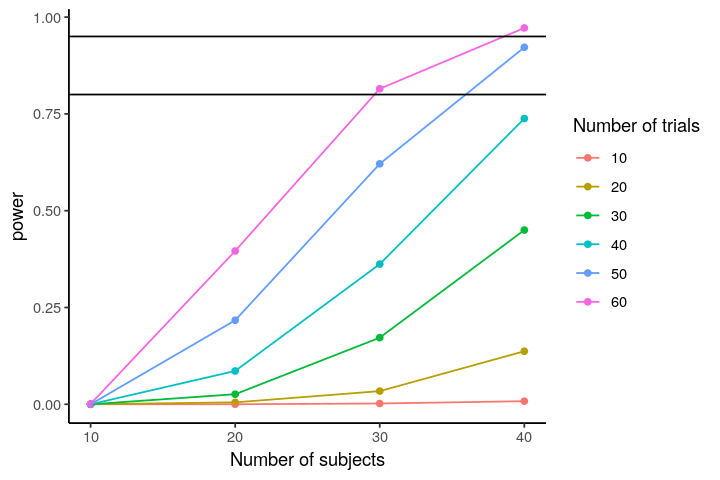

In [166]:
options(repr.plot.width=6)
ggplot(results, aes(sample_size, power, color=as.factor(alpha), group=alpha)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) + 
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('Alpha level') +
    scale_x_continuous('Sample size') +
    theme_classic()

You can see that for a power of 80%, you need 14 people per group to detect a difference in height at the 0.001 threshold for significance.  Progressively fewer subjects are needed to reach the same power at less stringent alpha thresholds. 

### Extending to more complicated analyses: Example with mixed-models

The basic procedure outlined above and the functions presented can be extended to any type of analysis in which there is a discrete threshold for making significance decisions. The only thing that has to be changed is the generation of the data and the analysis function. In generating the data, the most complicated thing is specifying the variance structure. 

Let's take for example a mixed-effects regression of reaction times in a priming lexical decision experiment. We are interested in whether people make lexical decision ('Is this string a word or not?') faster after semantically congruent rather than semantically incongruent items. 

How do we generate data for this? Typical psycholinguistic experiments use repeated measures designs where each participant performs many trials in each condition. The reaction time to any trial is determined by:

- mean of each condition (expected population priming effect)
- individual differences in:
    - overall speed (different intercepts for each subject)
    - difference between conditions (some people might be more strongly affected by the manipulation than others)
- trial-by-trial variation


So our mixed effects model and data structure would be as follows:

$$RTs = \beta_{subject\_intercept} + \beta_{subject\_slope} * condition + \epsilon_{trial}$$

$$\beta_{subject\_intercept} = \beta_{overall\_intercept} + \epsilon_{intercept}$$

$$\beta_{subject\_slope} = \beta_{mean\_difference} + \epsilon_{slope}$$

$$\epsilon_{trial} \sim \mathcal{N}(0, \sigma_{trial}^2)$$

$$\epsilon_{intercept} \sim \mathcal{N}(0, \sigma_{intercept}^2)$$

$$\epsilon_{slope} \sim \mathcal{N}(0, \sigma_{slope}^2)$$

In our simulation, then, we need to specify 5 parameters for the data generation:
- $\beta_{overall\_intercept}$ (Average RTs for congruent primes)
- $\beta_{mean\_difference}$ (Average RT difference between congruent and incongruent primes)
- $\sigma_{trial}$ (The standard deviation of RTs on each trial, if each participant responds to the same item)
- $\sigma_{intercept}$ (How much individual subjects vary in their overall speed)
- $\sigma_{mean\_difference}$ (How much individual subjects vary in how strongly they are affected by priming)

Let's pick some plausible parameters based on prior literature and educated guessing:

$$\beta_{overall\_intercept} = 700 ms.$$

$$\beta_{mean\_difference} = 50 ms.$$

$$\sigma_{trial} = 200 ms.$$

$$\sigma_{intercept} = 100 ms.$$ 

$$\sigma_{mean_difference} = 50 ms.$$

How many subjects and trials per subject do we need to achieve 80% power? Let's adapt our functions.

In [146]:
library(lme4)

# a function for simulating data for mixed-model.
simulate_data <- function(n_subjects, n_trials, intercept, 
                          slope, intercept_sd, slope_sd, trial_sd) {
    # draw observation from a normal distribution
    subject_intercepts <- rnorm(n_subjects, intercept, intercept_sd)
    subject_slopes <- rnorm(n_subjects, slope, slope_sd)
    dat <- data.frame(subject = 1:n_subjects, intercept = subject_intercepts, slope=subject_slopes)
    # generate trials for each subject
    dat <- dat  %>% 
        nest(-subject, .key = parameters)  %>% 
        mutate(congruent = map(parameters, ~rnorm(n_trials, intercept, trial_sd)),
               incongruent = map(parameters, ~rnorm(n_trials, intercept+slope, trial_sd)))  %>% 
        unnest(congruent,incongruent, .drop = FALSE)  %>% 
        unnest(parameters)  %>% 
        gather(prime, rt, congruent, incongruent)
    return(dat)
}


# a function for running a mixed-model and extract p-value
run_analysis <- function(data) {
    # fit null and alternative model
    m0 <- lmer(rt ~ 1 + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE))
    m1 <- lmer(rt ~ prime + (prime||subject), data=data, REML=FALSE, control=lmerControl(calc.derivs = FALSE))
    #You can replace with change in AIC or a p-value for a likelihood ratio statistic
    m_bic <- BIC(m0, m1)$BIC
    statistic <- diff(m_bic)
    return(statistic)
}

Before we run the full analysis, just for demonstration, here is simulated data for some subjects:

In [147]:
set.seed(04082019)
dat <- simulate_data(10, 10, 700, 50, 100,50,200)
head(dat, n=20)

subject,intercept,slope,prime,rt
1,597.2636,44.90354,congruent,768.7063
1,597.2636,44.90354,congruent,824.4766
1,597.2636,44.90354,congruent,819.0639
1,597.2636,44.90354,congruent,274.4973
1,597.2636,44.90354,congruent,1027.7488
1,597.2636,44.90354,congruent,665.0339
1,597.2636,44.90354,congruent,719.1601
1,597.2636,44.90354,congruent,760.2116
1,597.2636,44.90354,congruent,786.2429
1,597.2636,44.90354,congruent,640.1712


And here's the output of the model concerning the effect of priming:

In [148]:
run_analysis(dat)

[1] 5.190943

Let's run the simulation for various number of subjects and trials. This takes a long time, btw.

In [160]:
# a function for repeatedly running the analysis on multiple samples drawn with the same parameters
repeat_analysis <- function(n_simulations, alpha, n_subjects, n_trials, intercept, slope, intercept_sd, slope_sd, trial_sd) {
    bic_diffs <- c() # empty vector to store delta BICs from each simulation
    # loop for repeating the simulation
    for (i in 1:n_simulations) {
        data <- simulate_data(n_subjects, n_trials, intercept,
                              slope, intercept_sd, slope_sd, trial_sd)
        bic_diff <- run_analysis(data)
        bic_diffs <- c(bic_diffs,bic_diff) # add the current p.value to the vector
    }
    
    # calculate how many of the simulations had significant results
    power <- mean(bic_diffs <= -20) #strong evidence, see Raftery & Kass 1995
    return(list(power = power, bic_diffs = bic_diffs))
}

In [161]:
dat <- expand.grid(n_subjects = c(10,20,30,40), n_trials = c(10,20,30,40,50,60))
dat$id <- 1:nrow(dat)

# then use tidyverse functions to run the analysis for each sample size (takes ~30-60 minutes)
results <- dat  %>% 
    nest(-id, .key = 'parameters')  %>% 
    mutate(power = map(parameters, ~ repeat_analysis(1000, 0.05, .$n_subjects, .$n_trials, 700, 50, 100,50,200)$power))  %>% 
    unnest(parameters, power)

In [167]:
results

id,power,n_subjects,n_trials
1,0.000,10,10
2,0.000,20,10
3,0.002,30,10
4,0.008,40,10
5,0.000,10,20
6,0.005,20,20
7,0.034,30,20
8,0.137,40,20
9,0.000,10,30
10,0.026,20,30


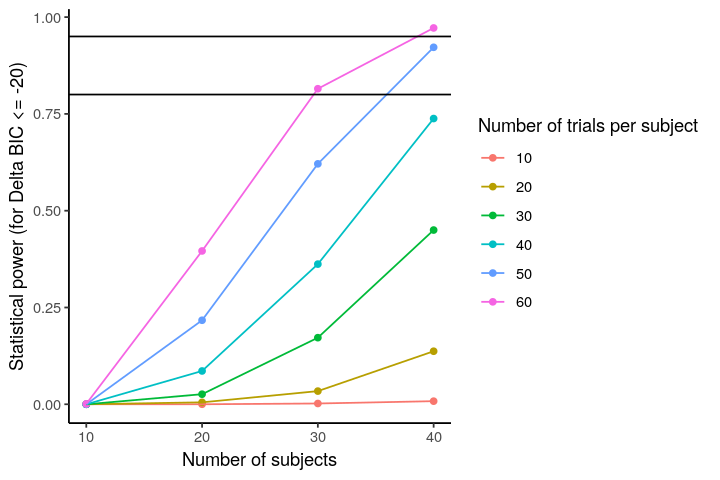

In [169]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(results, aes(n_subjects, power, color=as.factor(n_trials), group=n_trials)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.8) +
    geom_hline(yintercept = 0.95) +
    scale_color_discrete('Number of trials per subject') +
    scale_x_continuous('Number of subjects') +
    scale_y_continuous('Statistical power (for Delta BIC <= -20)') +
    theme_classic()

So, you can see that power, at least given these variability parameters, is a function of both the number of subjects and the number of trials per subject. 

In this case 30 subjects with 60 trials per subject results in ~80% power, but using 40 subjects with up to 40 trials per subject is not enough to reach ~80% power. 

#### But what is more important, # subjects or # trials?

This depends on the relative sizes of the $\sigma_{trial}$ and $\sigma_{slope}$, i.e., how much observations vary from trial to trial, and how much the true effect varies from subject to subject. If the variability associated wtih the $sigma_{slope}$ is relatively large, adding more subjects will be more important for estimating the population level difference, because it will improve its estimation more than adding more trials. If however people are more homogeneous, and respond similarly to the manipulation, then adding more trials would be more efficient. To test this out, you can run the above simulation for different values of $\sigma_{trial}$ and $\sigma_{slope}$, and see it for yourself.

Notebook authored by Ven Popov. Edited by Krista Bond. 